通过朴素的策略梯度更新方法求解迷宫问题（强化学习初步）

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

## basics

- $\theta$ 与 $\pi_\theta(s,a)$（给定 $\theta$（策略参数） 关于 s, a 的函数），基于 $\theta$ 找到 $\pi_\theta$
    - $\theta$ 是策略参数
    - $\pi_\theta(s,a)$ 是策略（base $\theta$，policy)
    - $\pi$ 表示 distribution
- 策略迭代（策略梯度，policy gradient）的含义
    - $\theta_0\rightarrow \pi_0$, $\theta_0 \rightarrow \theta_1$, $\theta_1 \rightarrow \pi_1$

## 更新 pi 的计算方式

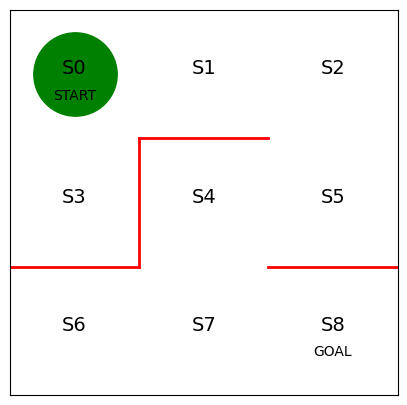

In [2]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

plt.plot([2, 3], [1, 1], color='red', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [1, 2], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
# plt.axis('off')
plt.tick_params(axis='both', which='both', 
                bottom=False, top=False, 
                right=False, left=False,
                labelbottom=False, labelleft=False
               )
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

In [3]:
# border & barrier
# ↑, →, ↓, ←（顺时针）
# row index: given state
# col index: posible action
# (state, action) matrix
# 跟环境对齐
theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )

In [4]:
# 基于占比, 最 naive 的概率化方式
def cvt_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

In [5]:
cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

$$
\begin{split}
\mathbb P_{k} & = \frac{\exp(z_k\cdot \beta)}{\sum_i \exp(z_i\cdot \beta)}\\
&=\frac{\exp(\frac{z_k}T)}{\sum_i \exp(\frac{z_i}T)}=\frac{\exp(\beta\cdot{z_k})}{\sum_i \exp(\beta\cdot{z_i})}
\end{split}
$$

In [6]:
# 基于 softmax，更 general 的概率化方式
def softmax_cvt_theta_0_to_pi(theta, beta=1.0):
    m, n = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta*beta)
    for r in range(m):
        pi[r, :] = exp_theta[r, :]/np.nansum(exp_theta[r, :])
    pi = np.nan_to_num(pi)
    return pi

In [7]:
softmax_cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

## 与环境（Env）交互

In [8]:
# 维护着状态，以及 step 函数的返回
class MazeEnv(gym.Env):
    def __init__(self):
        self.state = 0
        pass
    
    def reset(self):
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        if self.state == 8:
            done = True
        # state, reward, done, _
        return self.state, 1, done, {}

$$
\begin{split}
&\theta_{s_i,a_j}=\theta_{s_i,a_j}+\eta\cdot \Delta \theta_{s,a_j}\\
&\Delta \theta_{s,a_j}=\frac{1}T\cdot \left(N(s_i,a_j) - P(s_i,a_j)N(s_i,a)\right)
\end{split}
$$

In [ ]:
# 动作策略选择，基于当前环境的状态
class Agent:
    def __init__(self):
        self.actions = list(range(4))
        self.theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )
        self.theta = self.theta_0
        self.pi = self._softmax_cvt_theta_to_pi()
        self.eta = 0.1 # 类似深度学习中的学习率，设置梯度下降的步长

    def _cvt_theta_to_pi(self):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        for r in range(m):
            pi[r, :] = self.theta[r, :] / np.nansum(self.theta[r, :])
        return np.nan_to_num(pi)
    
    # 利用标准softmax公式，概率求和为1
    def _softmax_cvt_theta_to_pi(self, beta=1.):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        exp_theta = np.exp(self.theta*beta)
        for r in range(m):
            pi[r, :] = exp_theta[r, :] / np.nansum(exp_theta[r, :])
        return np.nan_to_num(pi)
    
    # 更新每一个state对应的动作概率密度函数，输入为[state, action]集合，实际上就是记录过去策略的执行历史（所谓的轨迹）
    # 然后参照上述公式，写出更新参数的代码
    def update_theta(self, s_a_history):
        T = len(s_a_history) - 1   # 总执行次数
        m, n = self.theta.shape
        delta_theta = self.theta.copy()
        for i in range(m):
            for j in range(n):
                if not(np.isnan(self.theta_0[i, j])):
                    sa_i = [sa for sa in s_a_history if sa[0] == i]  # 无关j，所以这里计算的是（si, a）集合
                    sa_ij = [sa for sa in s_a_history if (sa[0] == i and sa[1] == j)]  # 计算的是（si, aj）集合
                    N_i = len(sa_i)
                    N_ij = len(sa_ij)
                    delta_theta[i, j] = (N_ij - self.pi[i, j]*N_i)/T
        self.theta = self.theta + self.eta * delta_theta
        return self.theta
    
    def update_pi(self):  # 根据当前的theta更新动作概率分布
        self.pi = self._softmax_cvt_theta_to_pi()
        return self.pi
    
    def choose_action(self, state):
        # 依概率分布 \pi_\theta 选择 action
        action = np.random.choice(self.actions, p=self.pi[state, :])
        return action

In [10]:
env = MazeEnv()
agent = Agent()

In [ ]:
state = env.state
# state, action
# trajectory 记录运动轨迹，参数的更新即是基于轨迹
s_a_history = [[state, np.nan]]

In [12]:
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [13]:
len(s_a_history)

27

## update $\theta$ and $\pi_\theta$ base policy gradient

- $\theta_{s_i, a_j} = \theta_{s_i, a_j} + \eta \Delta\theta_{s_i, a_j}$
- $\Delta\theta_{s_i, a_j}=\frac{N(s_i, a_j)-P(s_i,a_j)\cdot N(s_i, a)}{T}$

In [40]:
env = MazeEnv()
agent = Agent()
state = 0
# state, action
s_a_history = [[state, np.nan]]
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break
print(s_a_history)

[[0, np.int64(1)], [1, np.int64(3)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(1)], [1, np.int64(3)], [0, np.int64(1)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(3)], [0, np.int64(1)], [1, np.int64(3)], [0, np.int64(1)], [1, np.int64(3)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(1)], [1, np.int64(1)], [2, np.int64(2)], [5, np.int64(0)], [2, np.int64(2)], [5, np.int64(0)], [2, np.int64(3)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(3)], [0, np.int64(1)], [1, np.int64(3)], [0, np.int64(1)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(3)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(1)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(3)], [0, np.int64(1)], [1, np.int64(1)], [2, np.int64(3)], [1, np.in

In [41]:
agent.update_theta(s_a_history)

array([[       nan, 1.00197368, 0.99802632,        nan],
       [       nan, 1.00131579,        nan, 0.99868421],
       [       nan,        nan, 0.99473684, 1.00526316],
       [1.        ,        nan,        nan,        nan],
       [       nan, 0.99934211, 1.00065789,        nan],
       [1.00131579,        nan,        nan, 0.99868421],
       [       nan, 1.        ,        nan,        nan],
       [0.9995614 , 1.00087719,        nan, 0.9995614 ]])

In [42]:
agent._softmax_cvt_theta_to_pi()

array([[0.        , 0.50098684, 0.49901316, 0.        ],
       [0.        , 0.50065789, 0.        , 0.49934211],
       [0.        , 0.        , 0.49736845, 0.50263155],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.49967105, 0.50032895, 0.        ],
       [0.50065789, 0.        , 0.        , 0.49934211],
       [0.        , 1.        , 0.        , 0.        ],
       [0.3331871 , 0.3336258 , 0.        , 0.3331871 ]])

## 完整训练及更新

In [43]:
stop_eps = 1e-4

In [44]:
agent = Agent()
env = MazeEnv()

while True:
    
    # 不断地从初始状态出发，产生一次 trajectory
    state = env.reset()
    # state, action
    s_a_history = [[state, np.nan]]
    while True:
        action = agent.choose_action(state)
        s_a_history[-1][1] = action
        state, reward, done, _ = env.step(action)
    #     print(action, state, done)
        s_a_history.append([state, np.nan])
        if state == 8 or done:
            break
            
    # 更新 theta，学习的过程，这里学习停止设置的条件是下一次更新的概率密度分布与上次的概率分布足够小就认为学习到了一个最优解，跳出
    agent.update_theta(s_a_history)
    pi = agent.pi.copy()
    # 更新 pi
    agent.update_pi()
    
    delta = np.sum(np.abs(agent.pi - pi))
    print(len(s_a_history), delta)
    if delta < stop_eps:
        break

69 0.008741964871511354
155 0.006466460439229937
43 0.016590190750899902
111 0.008059384311704276
83 0.005000156849088666
45 0.02032832751439978
21 0.02101980603326481
67 0.009793643197582469
49 0.008227266989568438
9 0.03683424605052016
71 0.011502954671089083
67 0.004754523839866909
115 0.009975425851494968
79 0.007290591839859251
25 0.012424756923390456
25 0.012499408593682149
21 0.022903093568212574
13 0.026249027351535725
41 0.007167817629336659
33 0.017059351946271173
21 0.034546433892531314
17 0.015604953669161648
17 0.01511646569884989
43 0.0134854681676016
37 0.007352859119442834
89 0.005936376954026601
49 0.009657845316157043
19 0.016373046688837656
19 0.016748504678567255
25 0.012308382550797303
105 0.005327278689120196
13 0.016722216064402218
45 0.021624936878245404
87 0.007770344560104836
55 0.008583876905527088
79 0.004683206879026569
13 0.03041995261450764
31 0.01614261732817268
17 0.02371741304550834
71 0.0074792363470148615
53 0.010036244790574744
85 0.0107634387088680

In [45]:
agent.pi

array([[0.        , 0.98509625, 0.01490375, 0.        ],
       [0.        , 0.98413185, 0.        , 0.01586815],
       [0.        , 0.        , 0.98557421, 0.01442579],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01528117, 0.98471883, 0.        ],
       [0.01492799, 0.        , 0.        , 0.98507201],
       [0.        , 1.        , 0.        , 0.        ],
       [0.01005281, 0.97734951, 0.        , 0.01259769]])

In [50]:
env = MazeEnv()
state = env.reset()
# state, action
s_a_history = [[state, np.nan]]
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [51]:
len(s_a_history)

7

In [52]:
from matplotlib import animation
from IPython.display import HTML

In [53]:
def init():
    line.set_data([], [])
    return (line, )
def animate(i):
    state = s_a_history[i][0]
    x = (state % 3)+0.5
    y = 2.5 - int(state/3)
    line.set_data([x], [y])

In [54]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())